In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import itertools
import seaborn as sns


In [10]:
def extract_information(description, word):
    # Regular expression to match the host information
    match = re.search(rf'{word}:([^()|]+)', description)
    if match:
        return match.group(1).strip()
    return None

In [11]:
from Bio import SeqIO
import re
#Data
records = list(SeqIO.parse("./ird_influenzaA_HA_allspecies.fa", "fasta"))
print(records[10])



ID: gb:CY066935|ncbiId:ADK33671.1|UniProtKB:D8KV23|Organism:Influenza
Name: gb:CY066935|ncbiId:ADK33671.1|UniProtKB:D8KV23|Organism:Influenza
Description: gb:CY066935|ncbiId:ADK33671.1|UniProtKB:D8KV23|Organism:Influenza A virus (A/Aarhus/INS236/2009(H1N1))|Strain Name:A/Aarhus/INS236/2009|Protein Name:HA Hemagglutinin|Gene Symbol:HA|Segment:4|Subtype:H1N1|Host:Human
Number of features: 0
Seq('MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH...ICI')


In [12]:
sequences = []
for record in tqdm(records):
    seq = str(record.seq)
    label = extract_information(record.description, "Host")
    type = extract_information(record.description, "Subtype")
    sequences.append((label, type, seq))


  0%|          | 0/94560 [00:00<?, ?it/s]

100%|██████████| 94560/94560 [00:00<00:00, 250453.33it/s]


In [13]:
total_seq = ""
for record in tqdm(records):
    total_seq += str(record.seq)
vocab = list(set(total_seq))
print(vocab)
print(len(vocab))
vocab_dict = {v: idx for idx, v in enumerate(vocab)}

100%|██████████| 94560/94560 [00:00<00:00, 628572.27it/s]

['W', 'L', 'P', 'K', 'J', 'Q', 'C', 'M', 'I', 'S', 'B', 'Y', 'E', 'A', 'R', 'N', 'X', 'G', 'T', 'D', 'H', 'F', 'V', 'Z']
24


In [14]:

datasets = defaultdict(list)
for label, type, seq in sequences:
    datasets[label].append(seq)

data = pd.DataFrame(sequences, columns=["Host", "Type" ,"Sequence"])
data


,Host,Type,Sequence
0,Sea Mammal,H7N7,MNTQILVFIACVLIEAKGDKICLGHHAVANGTKVNTLTERGIEVVN...
1,Human,H1N1,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTIFEKNVAVTHS...
2,Human,H1N1,MKARLLVLLCALAATDADTICIGYHANNSTDTVDTVLEKNVTVTHS...
3,Human,H1N1,MKARLLVLLCALAATDADTICIGYHANNSTDTVDTVLEKNVTVTHS...
4,Human,H1N1,MKAILVVLLYTFVTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...
...,...,...,...
94555,Human,H1N1,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...
94556,Human,H1N1,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...
94557,Human,H1N1,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...
94558,Mallard,H5N9,MERIVIALAIINIVKGDQICIGYHANNSTEQVDTIMEKNVTVTHAQ...


In [19]:
min_occ = 2000
max_occ = 20000

host_counts = data['Host'].value_counts()
hosts_more_than_2000_entries = host_counts[(host_counts > min_occ) & (host_counts < max_occ)].index.tolist()
filtered_data = data[data['Host'].isin(hosts_more_than_2000_entries)].reset_index(drop=True)

filtered_data = filtered_data[filtered_data.Host != "Unknown"]
filtered_hosts = filtered_data['Host'].unique()
print("Hosts with more than 2000 entries:")
# Assuming filtered_hosts is a list of unique hosts
host_counts = filtered_data["Host"].value_counts()

c = 0
for i in filtered_hosts:
    print(f"{i}: {host_counts.get(i, 0)}")
    c+=1
print(c)


Hosts with more than 2000 entries:
Swine: 13173
Duck: 3928
Mallard: 4626
Chicken: 9823
4


In [20]:
transition_matrices = {}

for species in tqdm(filtered_hosts, desc='Processing species'):
    pairs = {}

    # Extract and concatenate the 3-grams for the current species
    species_data = data_for_cluster[filtered_data["Host"] == species]["Sequence"].values
    
    # Convert each sequence to a list of characters and then concatenate
    concat_data = np.concatenate([list(seq) for seq in species_data])

    if len(concat_data) == 0:
        # Skip species with no data
        print(f"No data available for species: {species}")
        continue
    
    # Initialize the transition matrix
    transition_matrix = np.zeros((len(vocab), len(vocab)))  # Assuming 256 possible characters
    
    # Calculate transitions
    for current_state, next_state in tqdm(zip(concat_data[:-1], concat_data[1:]), desc=f'Building transition matrix for {species}', leave=False, total=len(concat_data) - 1):
        transition_matrix[vocab_dict[current_state], vocab_dict[next_state]] += 1

    # Store the transition matrix
    transition_matrices[species] = transition_matrix


Processing species:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3926/2796823887.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  species_data = data_for_cluster[filtered_data["Host"] == species]["Sequence"].values
Processing species:   0%|          | 0/4 [00:00<?, ?it/s]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

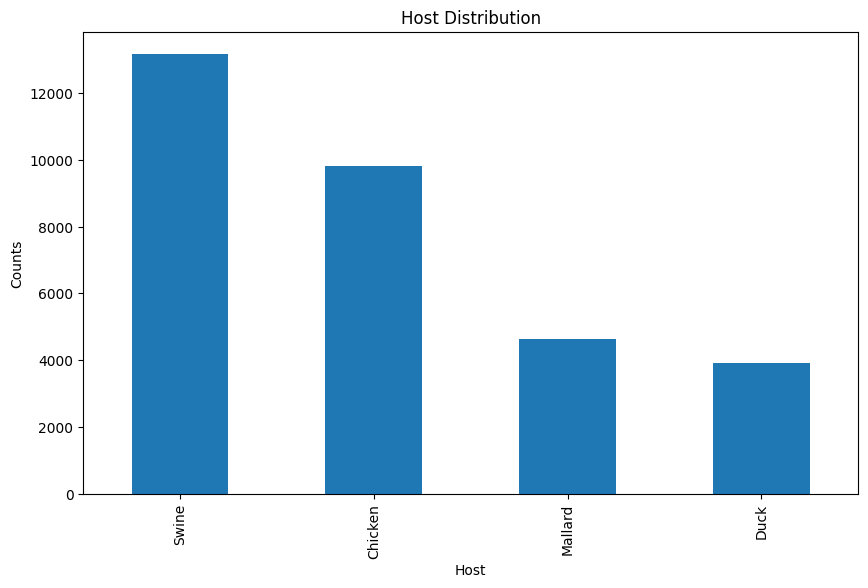

In [21]:
data_for_cluster = filtered_data.reset_index()
plt.figure(figsize=(10, 6))
data_for_cluster['Host'].value_counts().plot(kind='bar')
plt.title('Host Distribution')
plt.xlabel('Host')
plt.ylabel('Counts')
plt.show()

In [25]:
transition_matrices = {}

for species in tqdm(filtered_hosts, desc='Processing species'):
    pairs = {}

    # Extract and concatenate the 3-grams for the current species
    species_data = data_for_cluster[filtered_data["Host"] == species]["Sequence"].values
    
    # Convert each sequence to a list of characters and then concatenate
    concat_data = np.concatenate([list(seq) for seq in species_data])

    if len(concat_data) == 0:
        # Skip species with no data
        print(f"No data available for species: {species}")
        continue
    
    # Initialize the transition matrix
    transition_matrix = np.zeros((len(vocab), len(vocab)))  # Assuming 256 possible characters
    
    # Calculate transitions
    for current_state, next_state in tqdm(zip(concat_data[:-1], concat_data[1:]), desc=f'Building transition matrix for {species}', leave=False, total=len(concat_data) - 1):
        transition_matrix[vocab_dict[current_state], vocab_dict[next_state]] += 1

    # Store the transition matrix
    transition_matrices[species] = transition_matrix

Processing species: 100%|██████████| 4/4 [00:21<00:00,  5.25s/it]


In [22]:
# Function to calculate and visualize differences between transition matrices
def visualize_transition_matrix_differences(transition_matrices, vocab):
    species_pairs = list(itertools.combinations(transition_matrices.keys(), 2))
    
    for species1, species2 in species_pairs:
        matrix1 = transition_matrices[species1]
        matrix2 = transition_matrices[species2]
        
        # Calculate the difference
        difference_matrix = matrix1 - matrix2
        
        # Plot the difference matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(difference_matrix, xticklabels=vocab, yticklabels=vocab, cmap="magma", center=0)
        plt.title(f'Difference in Transition Matrix: {species1} vs {species2}')
        plt.xlabel('Next State')
        plt.ylabel('Current State')
        plt.show()


In [23]:
def normalize_transition_matrices(transition_matrices):
    normalized_matrices = {}
    for species, matrix in transition_matrices.items():
        row_sums = matrix.sum(axis=1)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1
        normalized_matrix = matrix / row_sums[:, np.newaxis]
        normalized_matrices[species] = normalized_matrix
    return normalized_matrices

normalized_transition_matrices = normalize_transition_matrices(transition_matrices)
#visualize_transition_matrix_differences(normalized_transition_matrices, vocab)


In [24]:
import math

def normalize_transition_matrices(transition_matrices):
    normalized_matrices = {}
    for species, matrix in transition_matrices.items():
        row_sums = matrix.sum(axis=1)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1
        normalized_matrix = matrix / row_sums[:, np.newaxis]
        normalized_matrices[species] = normalized_matrix
    return normalized_matrices

# Function to calculate and visualize differences between transition matrices
def visualize_transition_matrix_differences(transition_matrices, vocab):
    species_pairs = list(itertools.combinations(transition_matrices.keys(), 2))
    num_pairs = len(species_pairs)
    
    # Determine grid size
    cols = math.ceil(math.sqrt(num_pairs))
    rows = math.ceil(num_pairs / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for ax, (species1, species2) in zip(axes, species_pairs):
        matrix1 = transition_matrices[species1]
        matrix2 = transition_matrices[species2]
        
        # Calculate the difference
        difference_matrix = matrix1 - matrix2
        
        # Plot the difference matrix
        sns.heatmap(difference_matrix, xticklabels=vocab, yticklabels=vocab, cmap="magma", center=0, ax=ax)
        ax.set_title(f'Difference in Transition Matrix: {species1} vs {species2}')
        ax.set_xlabel('Next State')
        ax.set_ylabel('Current State')
    
    # Hide any unused subplots
    for i in range(num_pairs, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

normalized_transition_matrices = normalize_transition_matrices(transition_matrices)
visualize_transition_matrix_differences(normalized_transition_matrices, vocab)

ZeroDivisionError: division by zero

In [ ]:
# Function to compute difference metrics between two matrices
def compute_difference_metrics(matrix1, matrix2):
    frobenius_norm = np.linalg.norm(matrix1 - matrix2, 'fro')
    mse = np.mean((matrix1 - matrix2) ** 2)
    max_abs_diff = np.max(np.abs(matrix1 - matrix2))
    return frobenius_norm, mse, max_abs_diff

# Store the results in a DataFrame
results = []

# Compare each pair of species' transition matrices
species_list = list(transition_matrices.keys())
for i in range(len(species_list)):
    for j in range(i + 1, len(species_list)):
        species1 = species_list[i]
        species2 = species_list[j]
        matrix1 = transition_matrices[species1]
        matrix2 = transition_matrices[species2]
        frobenius_norm, mse, max_abs_diff = compute_difference_metrics(matrix1, matrix2)
        results.append((species1, species2, frobenius_norm, mse, max_abs_diff))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Species1', 'Species2', 'Frobenius Norm', 'Mean Squared Error', 'Max Absolute Difference'])

# Print the results
results_df

,Species1,Species2,Frobenius Norm,Mean Squared Error,Max Absolute Difference
0,Swine,Duck,359246.784303,2.240595e+08,62191.0
1,Swine,Mallard,335620.799826,1.955578e+08,60341.0
2,Swine,Chicken,237256.330655,9.772668e+07,43851.0
3,Duck,Mallard,37728.011079,2.471185e+06,9386.0
4,Duck,Chicken,227439.706375,8.980698e+07,42332.0
5,Mallard,Chicken,214183.165916,7.964311e+07,43782.0


# Generating sequences

In [35]:
# Sta roba mi serve solo se devo generare quindi la metto qua
animal_stats = {}
grouped_data = data_for_cluster.groupby('Host')

for animal, group in grouped_data:
    sequence_lengths = group['Sequence'].apply(len)
    min_length = sequence_lengths.min()
    max_length = sequence_lengths.max()
    
    starting_letters = group['Sequence'].str[0]
    letter_counts = Counter(starting_letters)
    total_sequences = len(group)
    start_letter_probabilities = {letter: count / total_sequences for letter, count in letter_counts.items()}
    
    animal_stats[animal] = {
        'min_length': min_length,
        'max_length': max_length,
        'start_letter_probabilities': start_letter_probabilities
    }

for animal, stats in animal_stats.items():
    print(f"Animal: {animal}")
    print(f"  Min Length: {stats['min_length']}")
    print(f"  Max Length: {stats['max_length']}")
    print(f"  Start Letter Probabilities: {stats['start_letter_probabilities']}")
    print()


Animal: Chicken
  Min Length: 547
  Max Length: 576
  Start Letter Probabilities: {'M': 0.9995927924259391, 'R': 0.00010180189351521938, 'G': 0.00010180189351521938, 'V': 0.00020360378703043877}

Animal: Duck
  Min Length: 510
  Max Length: 575
  Start Letter Probabilities: {'M': 0.9997454175152749, 'V': 0.0002545824847250509}

Animal: Mallard
  Min Length: 459
  Max Length: 570
  Start Letter Probabilities: {'M': 1.0}

Animal: Swine
  Min Length: 357
  Max Length: 576
  Start Letter Probabilities: {'M': 1.0}



In [43]:
import random

def generate_sequence(transition_matrix, species , vocab, vocab_dict, start_char='M'):
    max_length = animal_stats[species]['max_length']
    min_length = animal_stats[species]['min_length']
    sequence_length = random.randint(min_length, max_length) 
    current_char = start_char
    generated_sequence = [current_char]
    
    for _ in range(sequence_length - 1):  
        current_index = vocab_dict[current_char]
        transition_probabilities = transition_matrix[current_index]
        transition_probabilities /= np.sum(transition_probabilities)  
        next_char = np.random.choice(vocab, p=transition_probabilities)
        
        generated_sequence.append(next_char)
        current_char = next_char
    return ''.join(generated_sequence)


# Generating sequences for all species in the transition_matrices dictionary
generated_sequences = {}
for species, matrix in transition_matrices.items():
    sequence = generate_sequence(matrix, species, vocab, vocab_dict)
    generated_sequences[species] = sequence

# Print a few generated sequences
for species, seq in generated_sequences.items():
    print(f"{species}: {seq[:]}")  

Swine: MVRTQICDWPFQTSALVDGATIGITAYFTLIAIDLENKNLQFRIWTLKNENSWPKVECTCKYWTPMNITQCEEIDAIIACIVGSTCYHKSEKATYQDLFYSSYKGTIYYRIQNGRYYIDGMVKYHDFTPMVTRRVWICMKTVKGLSSKNRINGNFAIQSFQNTIGSSTGNLSWTATSYPGSTSRNRHKELGWMDTYYIFLKSTSTYNVSFIYAQASWYEQIRYLVGLLISGDINSLENIPTVTKLCILEKNLLNGVRMCNGFSVLDIGDYAPIACIAIHPNLIAIADSFGTIEQNSQEKEKLVSLFCQQLYNGRGNELLESTGTSTYSEPEQTNLGSILWTCNALDQEFSQNQIDLEVTSINAIYVK
Duck: MTCIDVAIAEFFYASNPIKILGSEQNIRSSGKYAAQLNTYEERIEVMEQREATIMIGNNVWSNLKMERKGNSKSSGNANRIHSKQNKLYKGYARNPLYADVFHDWTRARPLLRFGLNTDCDGDLGLKILLGSPKCILLFLVSDHEATQNDNRQIGGFNGLLPLLDNKSTPRPQVKYHTGVENTIKTYHILRMEIKEYNGLWTLCFSLTYGNKSLVLLQSYVGIELWSVLTFQTMKILVKLNPQVKLDCNRGTVNGVDKTHNNGNLKTINGIGWIEICRNDYNLQIWSFMNEKKSCNNDCSGNLTKKIENLGRRLWANKLKPQILFTVTGLDGDDVRRRRTRTGNGNDVRPEKYGAEIVTSTILDYQHDKPGAVGICILGSETRLVHEEGRGSPTTLIEDASKGTHDRLCMERILLNETQIMRENLQVKEEANAGFSINTLSVEGGQAPPEQDGCIEQHAVERENRDGSKGDCQKRNPGYHHPRRAAYSLASFLWACICPSNKVTDVERISVTELLLVDVSDQM
Mallard: MELLYRIAVKGHDNVERPGDSTNVWTIEGWLDTQGFEKFSAGNALESRLNGRGWIESKLITVPGLGSNAPYNKNLGWIETDCIAIP

In [46]:
import pandas as pd

# Define the number of sequences you want per species
num_sequences_per_species = 1000

# List to hold the data for each row
data = []

# Generating sequences for all species in the transition_matrices dictionary
for species, matrix in transition_matrices.items():
    for _ in tqdm(range(num_sequences_per_species)):
        sequence = generate_sequence(matrix, species, vocab, vocab_dict)
        data.append({'Host': species, 'Sequence': sequence})

# Convert the list of dictionaries into a pandas DataFrame
sequences_df = pd.DataFrame(data)

# Display the DataFrame
sequences_df


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s]


,Host,Sequence
0,Swine,MEQIEGNESTAVRSSIFGFAPNEGNKYVTHPHHTNGYVAVERCNLN...
1,Swine,MGSDKVAAKILYISGYQLFQTLSYFQLINGNGGMIVVQICPKCFNY...
2,Swine,MVRIDSLVLFNAVKAYAIQCKEEGIRSLSNNTDIIDDQIYAAKESE...
3,Swine,MNYNANHAPWLCDSFWTVKYNEKGEVSNHDGCDLSLLSWLPRMRVQ...
4,Swine,MNGRGSTVKNAIEFNITDDTYAFEFYPDEKMCICPNTGSGYITDLI...
...,...,...
3995,Chicken,MCQCAKIKVICDLETESDDKICIINERSTLMAVAPTSAAFHGMEGR...
3996,Chicken,MNKGLTENMETIFQGRFQKILPIWYKRIDKSLPSVEKLVQHPGLIE...
3997,Chicken,MCTSGWNGAPDDIRRTESNFPLFIWSSNELRKYNAVSRSYEYNVSH...
3998,Chicken,MLFIAFSKCTNEFGGLKIAVQKKIDLEKIAARSSSDFYPFYGRPSG...


In [47]:
sequences_df.to_csv('generated_sequences.csv', index=False)
